# **Import and preprocessing**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import math
from itertools import product
import numpy as np

In [14]:
#Import dataset and set sort ascending index "Date"
df = pd.read_csv("/content/NKG-Historical-Data.csv", parse_dates=['Date'], index_col='Date', sep=',')
df = df.sort_index(ascending=True)
print(df.head())

              Price     Open     High      Low     Vol. Change %
Date                                                            
2019-03-01  5,059.3  5,046.2  5,125.1  5,039.6  767.69K    0.00%
2019-03-04  5,223.6  5,256.5  5,289.3  5,125.1    1.92M    3.25%
2019-03-05  5,223.6  5,328.7  5,387.9  5,223.6    2.48M    0.00%
2019-03-06  5,118.5  5,223.6  5,256.5  5,118.5  697.98K   -2.01%
2019-03-07  4,934.5  5,217.0  5,217.0  4,934.5    1.29M   -3.59%


In [15]:
#Read type of dataset
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [16]:
df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('M', '').replace('K', '')) * (1e6 if 'M' in x else 1e3))

df['Change %'] = df['Change %'].str.replace('%', '')
df['Change %'] = df['Change %'].str.replace(',', '.').astype(float) / 100
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df.dropna(inplace=True)

print(df.dtypes)
df.head()

Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,5059.3,5046.2,5125.1,5039.6,767690.0,0.0000
2019-03-04,5223.6,5256.5,5289.3,5125.1,1920000.0,0.0325
2019-03-05,5223.6,5328.7,5387.9,5223.6,2480000.0,0.0000
2019-03-06,5118.5,5223.6,5256.5,5118.5,697980.0,-0.0201
2019-03-07,4934.5,5217.0,5217.0,4934.5,1290000.0,-0.0359


Ma trận tương quan:
             Price      Open      High       Low      Vol.  Change %
Price     1.000000  0.998551  0.999344  0.999333  0.579432  0.011632
Open      0.998551  1.000000  0.999457  0.999435  0.576682 -0.029441
High      0.999344  0.999457  1.000000  0.999360  0.583320 -0.013084
Low       0.999333  0.999435  0.999360  1.000000  0.572838 -0.011732
Vol.      0.579432  0.576682  0.583320  0.572838  1.000000  0.084546
Change %  0.011632 -0.029441 -0.013084 -0.011732  0.084546  1.000000


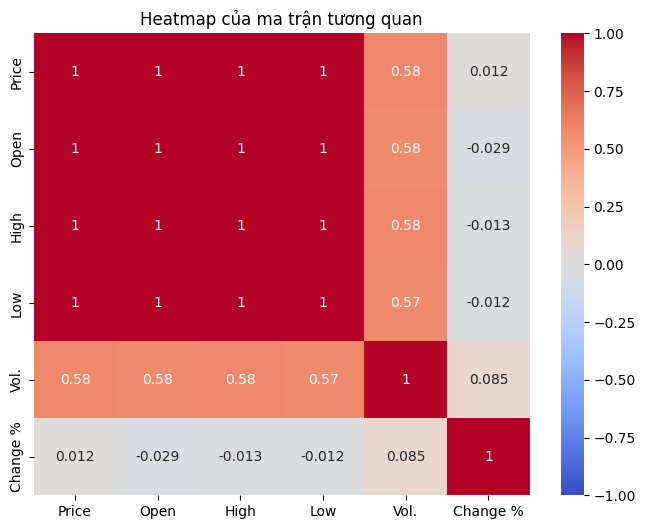

In [17]:
#Find best features for VARMA model by evaluate each features using heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.DataFrame(df)

corr_matrix = data.corr()

print("Ma trận tương quan:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap của ma trận tương quan')
plt.show()

In [18]:
#Choose best features from heatmap
df = df[["Price", "Open", "High", "Low"]]
df.head()

,Price,Open,High,Low
Date,,,,
2019-03-01,5059.3,5046.2,5125.1,5039.6
2019-03-04,5223.6,5256.5,5289.3,5125.1
2019-03-05,5223.6,5328.7,5387.9,5223.6
2019-03-06,5118.5,5223.6,5256.5,5118.5
2019-03-07,4934.5,5217.0,5217.0,4934.5


# **Split train, test by 90:10**

In [19]:
#Split train and test by 9:1
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]
train_df = train
train = np.asarray(train)

print(len(df))
print(len(train))
print(len(test))

1313
1181
132


In [ ]:
#Find best AR and MA for VARMA modeling by evalute AIC.
p_values = range(1, 5)
q_values = range(1, 5)

best_aic = np.inf
best_order = (0, 0)

for p in p_values:
    for q in q_values:
        try:
            model = VARMAX(data, order=(p, q))
            model_fit = model.fit(disp=False)

            aic = model_fit.aic

            print(f'VARMA({p}, {q}) - AIC: {aic}')

            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
        except Exception as e:
            print(f'VARMA({p}, {q}) - Error: {e}')

print(f'Best VARMA order: {best_order} - AIC: {best_aic}')

VARMA(1, 1) - Error: 5-th leading minor of the array is not positive definite
VARMA(1, 2) - Error: 5-th leading minor of the array is not positive definite
VARMA(1, 3) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.72365e-29): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.25548e-27): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estima

VARMA(1, 4) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 1) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 2) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.1544e-24): result may not be accurate.
  x = solve(lhs, q.flatten())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/

VARMA(2, 3) - Error: 5-th leading minor of the array is not positive definite
VARMA(2, 4) - Error: 5-th leading minor of the array is not positive definite


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/scipy/linalg/_solvers.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.75867e-21): result may not be accurate.
  x = solve(lhs, q.flatten())


KeyboardInterrupt: 

In [20]:
#Create model and training
model = VARMAX(train, order=(4, 1))
model_fit = model.fit(disp=False)

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                 1181
Model:                           VARMA(4,1)   Log Likelihood              -33063.826
                                + intercept   AIC                          66315.652
Date:                      Tue, 18 Jun 2024   BIC                          66792.619
Time:                              17:40:36   HQIC                         66495.463
Sample:                                   0                                         
                                     - 1181                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):         0.02, 0.01, 0.04, 0.00   Jarque-Bera (JB):   388.13, 2777.09, 3202.38, 1086.86
Prob(Q):                    0.89, 0.90, 0.84, 0.96   Prob(JB):                      0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H

In [21]:
#Forecast test dataset
forecast = model_fit.forecast(steps=len(test))

forecast = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print(forecast.head())

                   Price          Open          High           Low
Date                                                              
2023-11-16  21262.151167  21316.436844  21877.596796  20715.133958
2023-11-17  21488.713300  21357.332337  21895.132456  20850.062688
2023-11-20  21490.953382  21536.550920  21974.755914  20983.080624
2023-11-21  21487.763923  21538.569213  22000.756539  21026.716870
2023-11-22  21420.081888  21475.485345  21957.343078  20984.495650


**MAE, MAPE, RMSE**

In [22]:
#Determine MEAN and MAPE, RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error

mae = mean_absolute_error(test["Price"], forecast["Price"])
mape = mean_absolute_percentage_error(test["Price"], forecast["Price"])
rmse = np.sqrt(mean_squared_error(test["Price"], forecast["Price"]))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 3331.8603135147705
Mean Absolute Percentage Error (MAPE): 0.13651129791196753
Root Mean Squared Error (RMSE): 3565.4309803506467


# **Forecast next 30,60,90 days**

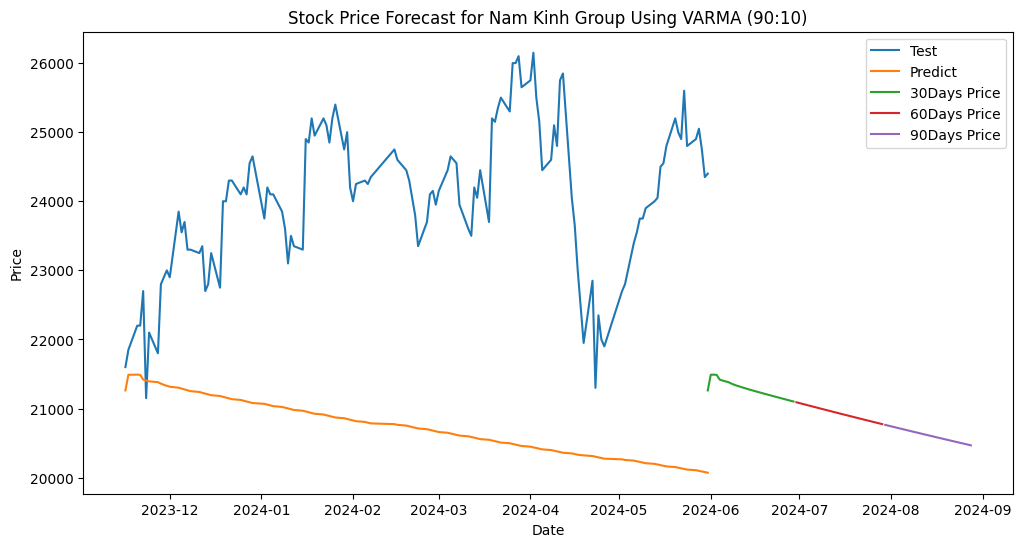

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

forecast_horizon = 90
next_90_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_90 = pd.DataFrame(next_90_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

forecast_horizon = 60
next_60_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_60 = pd.DataFrame(next_60_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

forecast_horizon = 30
next_30_days_forecast = model_fit.forecast(steps=forecast_horizon)
forecast_df_30 = pd.DataFrame(next_30_days_forecast, index=pd.date_range(start=df.index[-1], periods=forecast_horizon, freq='D'), columns=df.columns)

plt.plot(test.index, test["Price"], label='Test')

plt.plot(test.index, forecast["Price"], label='Predict')

plt.plot(forecast_df_30.index, forecast_df_30["Price"], label='30Days Price')

filtered_df_60 = forecast_df_60.iloc[30:60]

plt.plot(filtered_df_60.index, filtered_df_60["Price"], label='60Days Price')

filtered_df_90 = forecast_df_90.iloc[60:90]

plt.plot(filtered_df_90.index, filtered_df_90["Price"], label='90Days Price')

plt.title('Stock Price Forecast for Nam Kinh Group Using VARMA (90:10)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

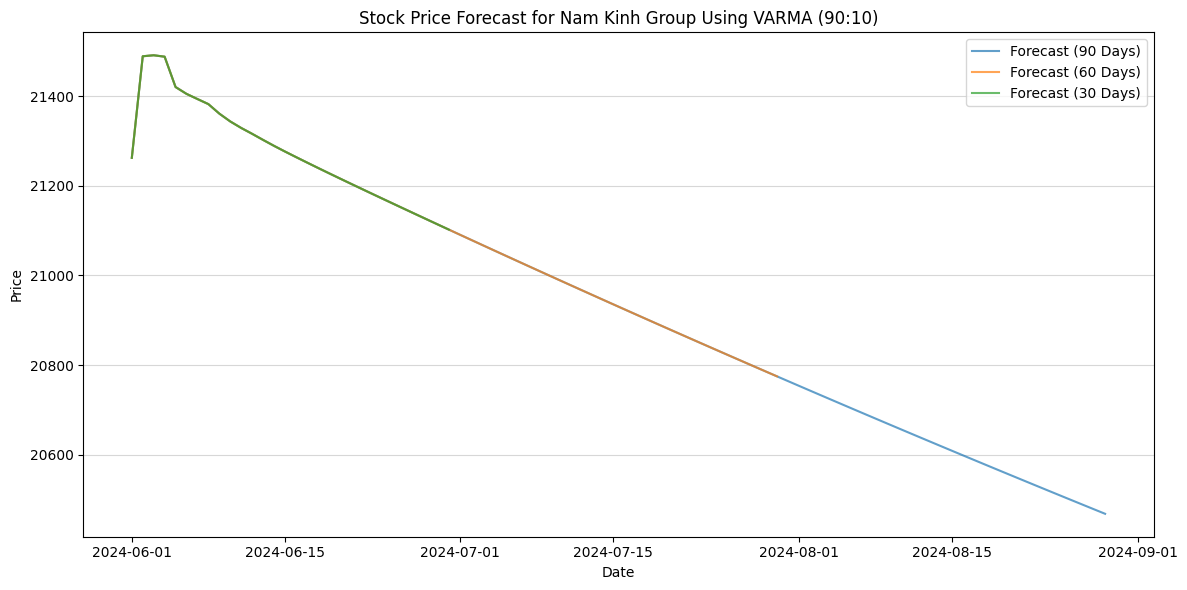

In [24]:
# Forecasting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

forecast_horizons = [90, 60, 30]
forecast_dfs = {}

for horizon in forecast_horizons:
    forecast = model_fit.forecast(steps=horizon)
    forecast_df = pd.DataFrame(
        forecast,
        index=pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=horizon, freq='D'),
        columns=df.columns
    )
    forecast_dfs[horizon] = forecast_df

for horizon, forecast_df in forecast_dfs.items():
    plt.plot(forecast_df.index, forecast_df["Price"],
             label=f'Forecast ({horizon} Days)', alpha=0.7)

plt.title('Stock Price Forecast for Nam Kinh Group Using VARMA (90:10)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()
